## Подключитесь к базе. Загрузите таблицы sql

In [1]:
!pip install imbalanced-learn -q

In [2]:
import psycopg2
import pandas as pd
import matplotlib.pyplot as plt
import gc
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sqlalchemy import create_engine

In [3]:
# Конфигурация подключения к базе данных
db_config = {
    'user': 'praktikum_student',
    'password': 'Sdf4$2;d-d30pp',
    'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
    'port': 6432,
    'database': 'data-science-vehicle-db'
}

# Создание строки подключения и подключения к базе данных
connection_string = f"postgresql://{db_config['user']}:{db_config['password']}@{db_config['host']}:{db_config['port']}/{db_config['database']}"
engine = create_engine(connection_string)

# Загрузка таблиц
collisions_query = "SELECT * FROM collisions;"
collisions_df = pd.read_sql(collisions_query, engine)

parties_query = "SELECT * FROM parties;"
parties_df = pd.read_sql(parties_query, engine)

vehicles_query = "SELECT * FROM vehicles;"
vehicles_df = pd.read_sql(vehicles_query, engine)

# Закрытие соединения
engine.dispose()

## Проведите первичное исследование таблиц

In [4]:
# Первичное исследование таблиц
collisions_df.info()
parties_df.info()
vehicles_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1400000 entries, 0 to 1399999
Data columns (total 20 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   case_id                      1400000 non-null  object 
 1   county_city_location         1400000 non-null  object 
 2   county_location              1400000 non-null  object 
 3   distance                     1400000 non-null  float64
 4   direction                    1059358 non-null  object 
 5   intersection                 1387781 non-null  float64
 6   weather_1                    1392741 non-null  object 
 7   location_type                518779 non-null   object 
 8   collision_damage             1400000 non-null  object 
 9   party_count                  1400000 non-null  int64  
 10  primary_collision_factor     1391834 non-null  object 
 11  pcf_violation_category       1372046 non-null  object 
 12  type_of_collision            1388176 non-n

##  Проведите статистический анализ факторов ДТП

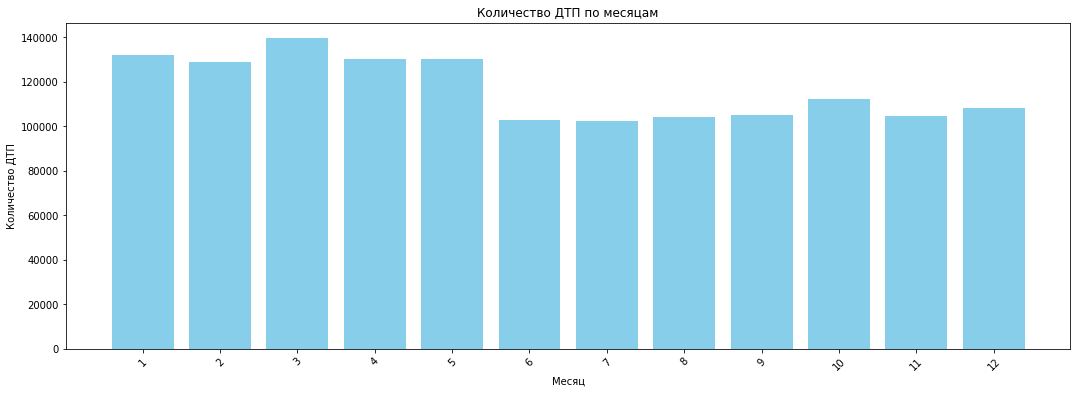

In [5]:
# Статистический анализ факторов ДТП по месяцам
query = """
SELECT EXTRACT(MONTH FROM collision_date) AS month, COUNT(*) AS accident_count
FROM collisions
GROUP BY month
ORDER BY month;
"""
accidents_by_month_df = pd.read_sql(query, engine)

# Построение графика количества ДТП по месяцам
plt.figure(figsize=(18, 6))
plt.bar(accidents_by_month_df['month'], accidents_by_month_df['accident_count'], color='skyblue')
plt.xlabel('Месяц')
plt.ylabel('Количество ДТП')
plt.title('Количество ДТП по месяцам')
plt.xticks(accidents_by_month_df['month'], rotation=45)
plt.show()

## Создайте модель для оценки водительского риска

In [6]:
# Запрос для получения данных о водителях автомобилей
query = """
SELECT p.case_id, p.party_type, p.party_sobriety, p.at_fault, c.collision_date, c.weather_1, v.vehicle_age
FROM parties p
JOIN collisions c ON p.case_id = c.case_id
JOIN vehicles v ON p.case_id = v.case_id AND p.party_number = v.party_number
WHERE p.party_type = 'car'
  AND c.collision_damage != 'SCRATCH'
  AND EXTRACT(YEAR FROM c.collision_date) = 2012;
"""
data_df = pd.read_sql(query, engine)

# Проверка данных
data_df.head()

,case_id,party_type,party_sobriety,at_fault,collision_date,weather_1,vehicle_age
0,5608536,car,had not been drinking,1,2012-05-03,raining,0.0
1,5600850,car,impairment unknown,0,2012-04-19,clear,NaN
2,5600885,car,had not been drinking,1,2012-04-19,clear,8.0
3,5600893,car,"had been drinking, under influence",1,2012-04-21,clear,6.0
4,5603123,car,had not been drinking,1,2012-04-13,cloudy,11.0


Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.69      0.67     17190
           1       0.58      0.55      0.56     13791

    accuracy                           0.62     30981
   macro avg       0.62      0.62      0.62     30981
weighted avg       0.62      0.62      0.62     30981



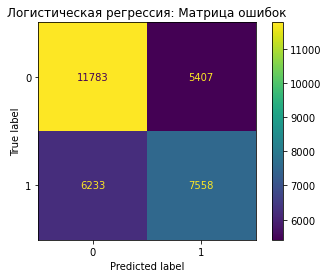

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.69      0.67     17190
           1       0.58      0.54      0.56     13791

    accuracy                           0.62     30981
   macro avg       0.62      0.61      0.62     30981
weighted avg       0.62      0.62      0.62     30981



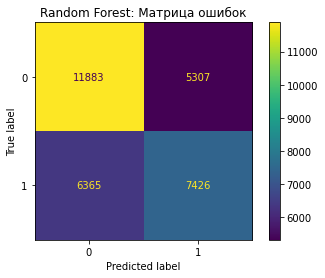

Gradient Boosting Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.87      0.72     17190
           1       0.67      0.33      0.45     13791

    accuracy                           0.63     30981
   macro avg       0.65      0.60      0.58     30981
weighted avg       0.64      0.63      0.60     30981



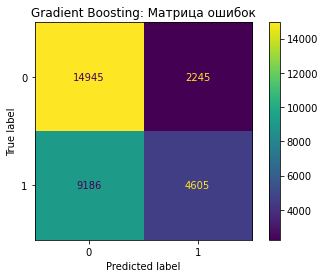

In [10]:
# Определение X и y
X = data_df[['party_sobriety', 'vehicle_age', 'weather_1']]  # Признаки
y = data_df['at_fault']  # Целевая переменная

# Импутация пропущенных значений и OneHotEncoder для категориальных признаков
imputer = SimpleImputer(strategy='most_frequent')
X_imputed = imputer.fit_transform(X)  # Заменяем пропуски

encoder = OneHotEncoder(handle_unknown='ignore')
X_encoded = encoder.fit_transform(X_imputed)  # Кодируем категориальные признаки

# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.3, random_state=42)

# 1. Логистическая регрессия
log_model = LogisticRegression(max_iter=100, class_weight='balanced')
log_model.fit(X_train, y_train)
y_pred_log = log_model.predict(X_test)

# Оценка логистической регрессии
print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred_log))

# Матрица ошибок для логистической регрессии
conf_matrix_log = confusion_matrix(y_test, y_pred_log)
ConfusionMatrixDisplay(conf_matrix_log).plot()
plt.title('Логистическая регрессия: Матрица ошибок')
plt.show()

# 2. Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

# Оценка Random Forest
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))

# Матрица ошибок для Random Forest
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
ConfusionMatrixDisplay(conf_matrix_rf).plot()
plt.title('Random Forest: Матрица ошибок')
plt.show()

# 3. Gradient Boosting Classifier
gb_model = GradientBoostingClassifier(n_estimators=100, random_state=42)
gb_model.fit(X_train, y_train)
y_pred_gb = gb_model.predict(X_test)

# Оценка Gradient Boosting
print("Gradient Boosting Classification Report:")
print(classification_report(y_test, y_pred_gb))

# Матрица ошибок для Gradient Boosting
conf_matrix_gb = confusion_matrix(y_test, y_pred_gb)
ConfusionMatrixDisplay(conf_matrix_gb).plot()
plt.title('Gradient Boosting: Матрица ошибок')
plt.show()

## Проведите анализ важности факторов ДТП

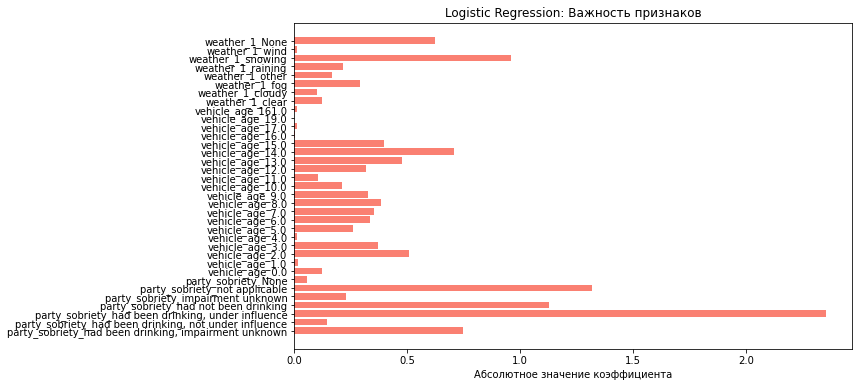

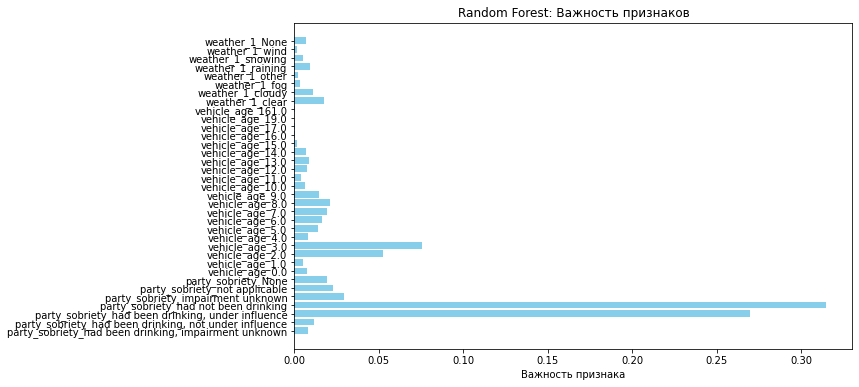

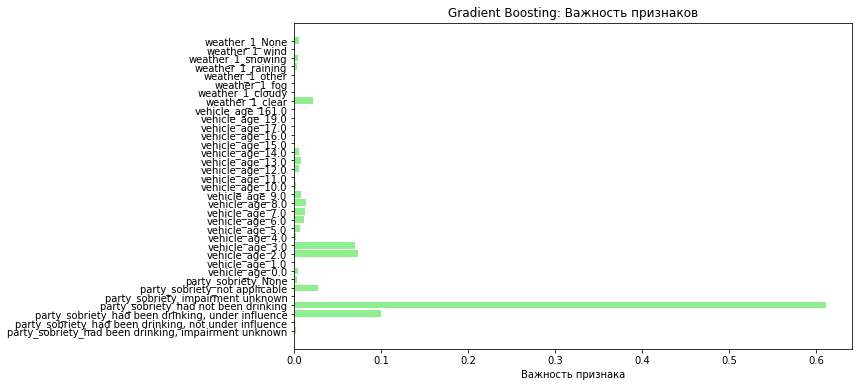

In [12]:
# 1. Получение коэффициентов логистической регрессии
coef_log = log_model.coef_[0]  # Коэффициенты для первой (и единственной) целевой переменной
abs_coef_log = np.abs(coef_log)  # Берем абсолютные значения коэффициентов

# 2. Преобразуем кодированные имена признаков для логистической регрессии, как и для Random Forest
feature_names_log = encoder.get_feature_names_out(input_features=X.columns)

# 3. Важность признаков для Logistic Regression
plt.figure(figsize=(10, 6))
plt.barh(feature_names_log, abs_coef_log, color='salmon')
plt.xlabel('Абсолютное значение коэффициента')
plt.title('Logistic Regression: Важность признаков')
plt.show()

# Анализ важности признаков для Random Forest
importances_rf = rf_model.feature_importances_
feature_names = encoder.get_feature_names_out(input_features=X.columns)

# Важность признаков для Random Forest
plt.figure(figsize=(10, 6))
plt.barh(feature_names, importances_rf, color='skyblue')
plt.xlabel('Важность признака')
plt.title('Random Forest: Важность признаков')
plt.show()

# Анализ важности признаков для Gradient Boosting
importances_gb = gb_model.feature_importances_

# Важность признаков для Gradient Boosting
plt.figure(figsize=(10, 6))
plt.barh(feature_names, importances_gb, color='lightgreen')
plt.xlabel('Важность признака')
plt.title('Gradient Boosting: Важность признаков')
plt.show()

Наиболее значимыми факторами для увеличения вероятности ДТП являются неблагоприятные погодные условия и состояние алкогольного опьянения водителя.

## Выводы